In [1]:
# import things
import KenGP as gp
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons

%load_ext autoreload
%autoreload 2


In [2]:
"""
# These are our constants
N = 5  # Number of variables
F = 8  # Forcing


def L96(x, t):
    #Lorenz 96 model with constant forcing
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, 30.0, 0.01)

x = odeint(L96, x0, t)

# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()
"""

'\n# These are our constants\nN = 5  # Number of variables\nF = 8  # Forcing\n\n\ndef L96(x, t):\n    #Lorenz 96 model with constant forcing\n    # Setting up vector\n    d = np.zeros(N)\n    # Loops over indices (with operations and Python underflow indexing handling edge cases)\n    for i in range(N):\n        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F\n    return d\n\n\nx0 = F * np.ones(N)  # Initial state (equilibrium)\nx0[0] += 0.01  # Add small perturbation to the first variable\nt = np.arange(0.0, 30.0, 0.01)\n\nx = odeint(L96, x0, t)\n\n# Plot the first three variables\nfig = plt.figure()\nax = fig.gca(projection="3d")\nax.plot(x[:, 0], x[:, 1], x[:, 2])\nax.set_xlabel("$x_1$")\nax.set_ylabel("$x_2$")\nax.set_zlabel("$x_3$")\nplt.show()\n'

In [3]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

In [4]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

In [5]:
begin = 0
end = 500
step = 1
tlen = int((end-begin)/step)
trainToTest = 0.66 # between 0 and 1
t = np.arange(begin, end, step)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 2
t0 = np.ones(dim) * 0.0 # np.zeros(dim)
t0[0] += 0.1

In [6]:
# Discrete Time Systems
"""
# Munch Model, includes a time lag explicitly
trueLag = 4
initval = 2
r = 1.75 # vals used are 8, 3.5, 2.5, 1.75
states = np.zeros((tlen,1))
for i in range(tlen):
    if i <= trueLag:
        states[i] = initval
    else: 
        states[i] = r*states[i-1]*np.exp(-states[i-1-trueLag]+rand.normal(0,0.1,1))

"""

# Logistic Map
"""
r = lambda t : 0.25 * np.sin(t/30) + 3.75
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
""" 

# Density Dependent Maturation

states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

print(states[:25])


[[  5.         300.        ]
 [  2.27595966 321.80061828]
 [  1.81111723 238.08414799]
 [  2.91588197 180.08228675]
 [  3.96699889 184.58964851]
 [  3.9812182  231.32727237]
 [  3.22901664 249.00093106]
 [  2.91056966 232.09351139]
 [  3.17287733 216.36596285]
 [  3.47104839 216.5314607 ]
 [  3.50650269 222.11616705]
 [  3.43170081 228.20555327]
 [  3.34063129 231.83672075]
 [  3.28970178 231.49310226]
 [  3.30833372 228.07414609]
 [  3.38447827 227.70556077]
 [  3.41286431 230.18241734]
 [  3.38879321 233.29395639]
 [  3.34993041 230.24666902]
 [  3.41640045 227.78152818]
 [  3.48082708 228.37496079]
 [  3.49150965 231.84788757]
 [  3.4474968  228.82753367]
 [  3.51455261 234.37571032]
 [  3.43696412 236.93449437]]


In [7]:

# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
"""
t0 = np.array([4,12,17])
states = odeint(Lorenz,t0,t)
# print(states)
# print(states)
# END STATIONARY SIMULATION
"""

# FROM DATA
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()
print(states)
"""
# END FROM DATA


# NON STATIONARY VERSION
"""
rho = 28        # rho = 28.0
sigma = 10       # sigma = 10.0
beta = 8.0 / 3.0  # beta = 8.0 / 3.0

deltaP = 1
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    states[i] = odeint(LorenzP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]
    sigma += deltaP
"""
# END NON STATIONARY


'\nrho = 28        # rho = 28.0\nsigma = 10       # sigma = 10.0\nbeta = 8.0 / 3.0  # beta = 8.0 / 3.0\n\ndeltaP = 1\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    states[i] = odeint(LorenzP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]\n    sigma += deltaP\n'

In [8]:
# Normalize, split data
states = (states - states.mean(0) ) / states.std(0) # normalize
testTrainSplit = int(states.shape[0] * trainToTest)

X = states[:-1]
Y = states[1:,]
    
# Xt = np.column_stack((X[testTrainSplit:,], X[testTrainSplit-1:-1,1]))
Xt = X[testTrainSplit:,]
Yt = Y[testTrainSplit:,]
X = X[:testTrainSplit,]
Y = Y[:testTrainSplit,]


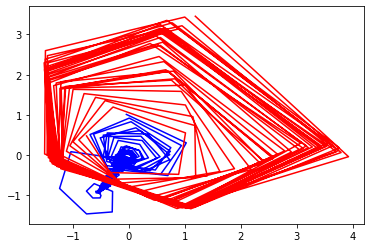

In [9]:
# Print Input
fig2 = plt.figure(2)
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(X,"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1],c="b")
    ax2.plot(Xt[:,0],Xt[:,1],c="r")
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(X[:,0],X[:,1],X[:,2])
    
plt.savefig("result-train_data.png")

np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)

"""
fig, (lor0, lor1, lor2) = plt.subplots(nrows=1,ncols=3, figsize = (24,6))
lor0.plot(X[:,0],"b")
lor1.plot(X[:,1],"b")
lor2.plot(X[:,2],"b")
"""

plt.show()

# print(X.flatten())

In [10]:
# GP setup
gp.setCovar("sqrexp")
# gp.setPrior(1,"half-normal")
gp.setPrior(2,"half-normal")
gp.setPrior(3,"exponential")
gp.setData(X,Y)
gp.setTimeDelayInterval(3)

assignment = [4,4]
gp.setTimeDelayEmbedding(assignment)
Xt, Yt = delayEmbed(Xt,Yt,assignment,1)
#print(gp.X)
numparams = 3
for i in range(numparams,numparams+sum(assignment)):
    gp.setPrior(i,"ARD")
embDim = sum(assignment)


#print(type(X),type(Y),type(assignment))


Prior dict  {0: 'none', 1: 'none', 2: 'none'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal'}
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential'}
Data input success
tmp  (330, 10)
r  [1.63569 1.57385 1.38382 1.33517 1.7436  1.6745  2.01426 2.01426]
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'none', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none'}
New X Dimensions  (306, 10)
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'ARD', 4: 'none', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'ARD', 4: 'ARD', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'ARD', 4: 'ARD', 5: 'ARD', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'ARD', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7:

In [11]:
# 2.96355967e-05 3.10039090e+00 6.52724514e-03 9.60568331e-01
 #9.60568331e-01 9.60568331e-01
# optimize them parameters

# gp.setHP([0, 0.50058, 0.15199])
gp.hyperParamOptimize(steps=40, yind=0) # <<<< THIS IS EXPENSIVE

Gradient:  [-0.99194 -0.0709  -0.01351 -0.02938 -0.0389  -0.03176 -0.04328 -0.0385
 -0.03786 -0.0317  -0.04074]
Likelihood:  187.05482264101155
Hp:  [0.45 0.45 0.45 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]  #  1
Gradient:  [-0.99494 -0.03431 -0.01118 -0.00545 -0.04107 -0.01037 -0.04487 -0.04055
 -0.03035 -0.02075 -0.04437]
Likelihood:  221.97012964512837
Hp:  [0.39 0.39 0.39 0.   0.   0.   0.   0.   0.   0.   0.  ]  #  2
Gradient:  [-0.41587  0.0051   0.0119   0.58704  0.04898  0.51036  0.11315  0.09126
  0.28398  0.33249  0.08409]
Likelihood:  255.4015887514462
Hp:  [0.318 0.42  0.42  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03 ]  #  3
Gradient:  [-0.99405 -0.01462 -0.00858  0.03725 -0.04853  0.02178 -0.04557 -0.04457
 -0.01858 -0.00078 -0.05432]
Likelihood:  321.70667192973826
Hp:  [0.2316 0.405  0.405  0.066  0.015  0.066  0.015  0.015  0.015  0.015
 0.015 ]  #  4
Gradient:  [-0.98891 -0.02155 -0.01111 -0.00646 -0.07457 -0.02614 -0.05662 -0.05765
 -0.04853 -0.02968 -0.07365]
Like

KeyboardInterrupt: 

In [13]:
print(gp.hp)

# One step predictions
diffTable = []
predictions = np.zeros((len(Xt),dim))
variances = np.zeros((len(Xt),1))
for i in range(len(Xt)):
    predTuple = gp.predict(Xt[i])
    variances[i] = predTuple[1]
    predictions[i] = predTuple[0] # list of one step prediction values for graphing
    
    diff = la.norm(Yt[i] - predictions[i]) # norm error for 1 step
    diffTable.append(diff)
# print("Predictions ", predictions)
# print("DiffTable ", diffTable)

diffTable = np.array(diffTable)

[0.00837 0.39476 0.26459 0.00838 0.00293 0.01204 0.00124 0.00629 0.01112
 0.02186 0.00485]


In [14]:
# feed forward prediction
"""
n = 200 # num steps
feedForwardPrediction = np.zeros(((n,dim)))
feedForwardPrediction[0] = X[0]
for i in range(n-1):
    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]
"""

'\nn = 200 # num steps\nfeedForwardPrediction = np.zeros(((n,dim)))\nfeedForwardPrediction[0] = X[0]\nfor i in range(n-1):\n    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]\n'

Mean Squared Error:  2.465028150472929


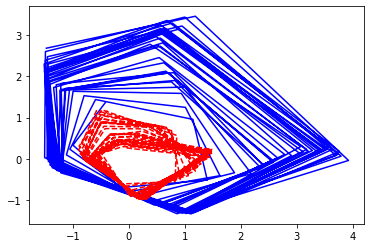

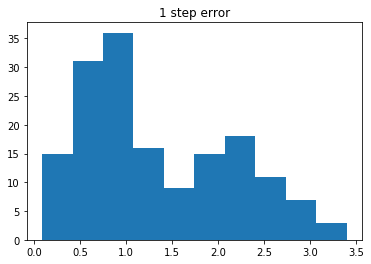

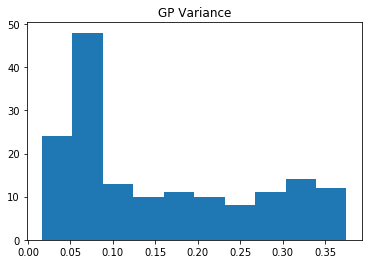

In [15]:
fig0 = plt.figure(0)
if dim == 1:
    ax0 = plt.subplot()
    ax0.plot(Yt[:75,0],"b") # states
    ax0.plot(predictions[:75,0],'--r')
elif dim == 2:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],Yt[:,1],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],'--r') # map of 1 step ahead predictions
else:
    ax0 = fig0.gca(projection="3d")
    ax0.plot(Yt[:,0],Yt[:,1],Yt[:,2],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],predictions[:,2],'--r') # map of 1 step ahead predictions
    # ax0.plot(feedForwardPrediction[:,0],feedForwardPrediction[:,1],feedForwardPrediction[:,2],'--g') # map of 50 step ahead prediction

plt.savefig("result-error_vs_actual.png")
    
fig1 = plt.figure(1)
plt.title("1 step error")
plt.hist(diffTable)

mse = sum(diffTable ** 2) / len(diffTable)
print("Mean Squared Error: ",mse)

plt.savefig("result-error_histogram.png")

fig2 = plt.figure(2)
plt.hist(variances)
plt.title("GP Variance")

"""
fig, (lor0, lor1, lor2) = plt.subplots(nrows=1,ncols=3, figsize = (24,6))
lor0.plot(Yt[:,0],"b")
lor1.plot(Yt[:,1],"b")
lor2.plot(Yt[:,2],"b")
lor0.plot(predictions[:,0],"--r")
lor1.plot(predictions[:,1],"--r")
lor2.plot(predictions[:,2],"--r")
"""

plt.savefig("result-error_vs_actual_individual_dims.png")

plt.show()

In [ ]:
# This doesn't work in Jupyter lol
fig3 = plt.figure(3)
sliderAx = plt.axes()
slider = Slider(sliderAx,"Tao", 0, 50, valinit=0, valstep=0.1)

fig4 = plt.figure(4)
paramAx = plt.axes()
paramButtons = RadioButtons(paramAx, ("rho","sigma","beta"), active = 0)

def update(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        rho = slider.val
    elif (paramButtons.value_selected == "sigma"):
        sigma = slider.val
    elif (paramButtons.value_selected == "beta"):
        beta = slider.val

    # Line Plot Update
    s = odeint(LorenzP,t0,t, args=(rho,sigma,beta))
    ax2.clear()
    ax2.plot(s[:,0], s[:,1], s[:,2])

    # Quiver Update
    mi = np.nanmin(s,axis=0)
    ma = np.nanmax(s,axis=0)
    st = abs(mi - ma) / 5
    print(st)

    x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
    u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
    ax2.quiver(x,y,z,u,v,w,length=5,normalize=True, color = "r", alpha = 0.25)
    
    fig2.canvas.draw()
    fig2.canvas.flush_events()

def update2(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        slider.set_val(rho)
    elif (paramButtons.value_selected == "sigma"):
        slider.set_val(sigma)
    elif (paramButtons.value_selected == "beta"):
        slider.set_val(beta)

slider.on_changed(update)
paramButtons.on_clicked(update2)

# Quiver Plot
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")


mi = np.nanmin(X,axis=0)
ma = np.nanmax(X,axis=0)
st = abs(mi - ma) / 5
print(st)

x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
ax2.quiver(x,y,z,u,v,w,length=st[0],normalize=True, color = "r", alpha=0.25)

plt.show()